In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
test_labels

array([2, 0, 2, 0, 1, 1, 0, 2, 0, 3, 1, 3, 1, 3, 2, 0, 0, 1, 0, 1, 2, 2,
       1, 2, 2, 1, 1, 3, 0, 1, 3, 0, 2, 1, 3, 3, 1, 0, 3, 0, 3, 2, 1, 0,
       0, 3, 0, 2, 2, 2, 0, 2, 2, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 1, 1,
       2, 2, 3, 1, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 3, 2, 3, 3, 2, 0,
       3, 1, 0, 0, 0, 2, 0, 0, 3, 2, 2, 0, 1, 0, 0, 1, 1, 1, 0, 3, 0, 0,
       0, 3, 3, 2, 2, 2, 0, 3, 3, 0, 2, 1, 3, 1, 2, 2, 0, 0, 3, 1, 1, 2,
       1, 0, 3, 0, 2, 0, 2, 2, 0, 3, 3, 3, 1, 0, 2, 0, 0, 0, 0, 1, 0, 3,
       2, 3, 0, 1, 2, 0, 1, 0, 1, 3, 2, 0, 0, 0, 0, 2, 3, 3, 1, 0, 3, 3,
       3, 1, 2, 3, 3, 1, 1, 0, 1, 2, 1, 0, 3, 0, 0, 0, 3, 2, 1, 1, 1, 3,
       0, 2, 2, 2, 0, 0, 2, 0, 3, 2, 1, 0, 3, 1, 2, 0, 0, 3, 2, 1, 2, 1,
       1, 3, 2, 1, 0, 3, 3, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 3, 2, 3, 1, 1,
       0, 0, 1, 0, 2, 3, 3, 0, 1, 0, 3, 2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2,
       3, 1, 2, 1, 0, 1, 3, 0, 1, 2, 1, 3, 0, 0, 0, 1, 2, 1, 2, 3, 0, 0,
       3, 0, 3, 0, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0,

In [6]:
# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

In [7]:
train_images.shape

(2913, 256, 256, 1)

In [8]:
# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

In [9]:
# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

In [10]:
# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

In [11]:
# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

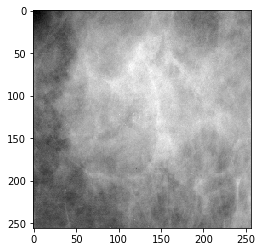

Label: [1. 0. 0. 0.]
[[[ 27.77647059  27.77647059  27.77647059]
  [ 30.23529412  30.23529412  30.23529412]
  [ 28.05098039  28.05098039  28.05098039]
  ...
  [ 96.97647059  96.97647059  96.97647059]
  [ 99.75294118  99.75294118  99.75294118]
  [101.4        101.4        101.4       ]]

 [[ 28.19607843  28.19607843  28.19607843]
  [ 29.18823529  29.18823529  29.18823529]
  [ 30.15294118  30.15294118  30.15294118]
  ...
  [ 96.49411765  96.49411765  96.49411765]
  [ 96.01568627  96.01568627  96.01568627]
  [ 99.8         99.8         99.8       ]]

 [[ 30.18823529  30.18823529  30.18823529]
  [ 31.35686275  31.35686275  31.35686275]
  [ 30.34509804  30.34509804  30.34509804]
  ...
  [102.52156863 102.52156863 102.52156863]
  [100.86666667 100.86666667 100.86666667]
  [102.87058824 102.87058824 102.87058824]]

 ...

 [[ 83.66666667  83.66666667  83.66666667]
  [ 86.51372549  86.51372549  86.51372549]
  [ 79.77254902  79.77254902  79.77254902]
  ...
  [119.28627451 119.28627451 119.2862745

In [12]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

print(train_images[0])

In [13]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_vgg16(verbose=False, fc_size=256, dropout=None):

    vgg16_base = VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    vgg16 = models.Sequential()
    vgg16.add(vgg16_base)

    vgg16.add(layers.Flatten())
    if dropout is not None:
        vgg16.add(layers.Dropout(dropout))
    vgg16.add(layers.Dense(fc_size, activation='relu'))
    vgg16.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    vgg16_base.trainable = False
    
    if verbose:
        vgg16_base.summary()
        vgg16.summary()

    return vgg16

In [14]:
vgg16_fe_drop_temp = create_vgg16(verbose=True, dropout=0.5, fc_size=256)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [15]:
vgg16_fe_drop_temp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8388864   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 8,389,892
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_128 = create_vgg16(dropout=0.5, fc_size=128)

In [17]:
vgg16_fe_drop_128.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

?EarlyStopping

?ModelCheckpoint

In [19]:
# Train
history_vgg16_fe_drop_128 = vgg16_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 6.4830 - accuracy: 0.3041
Epoch 00001: val_loss improved from inf to 1.37344, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 6.2252 - accuracy: 0.3072 - val_loss: 1.3734 - val_accuracy: 0.3316
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3778 - accuracy: 0.3527
Epoch 00002: val_loss improved from 1.37344 to 1.34871, saving model to vgg16_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3749 - accuracy: 0.3531 - val_loss: 1.3487 - val_accuracy: 0.3351
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3721 - accuracy: 0.3513
Epoch 00003: val_loss did not improve from 1.34871
19/19 [==============================] 

18/19 [===========================>..] - ETA: 1s - loss: 1.2436 - accuracy: 0.4217
Epoch 00027: val_loss did not improve from 1.20846
19/19 [==============================] - 29s 2s/step - loss: 1.2473 - accuracy: 0.4239 - val_loss: 1.2675 - val_accuracy: 0.4347
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2383 - accuracy: 0.4580
Epoch 00028: val_loss did not improve from 1.20846
19/19 [==============================] - 29s 2s/step - loss: 1.2426 - accuracy: 0.4547 - val_loss: 1.2523 - val_accuracy: 0.4175
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2470 - accuracy: 0.4380
Epoch 00029: val_loss did not improve from 1.20846
19/19 [==============================] - 29s 2s/step - loss: 1.2430 - accuracy: 0.4432 - val_loss: 1.2630 - val_accuracy: 0.4433
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2425 - accuracy: 0.4408
Epoch 00030: val_loss did not improve from 1.20846
19/19 [==============================]

In [20]:
# Save
models.save_model(vgg16_fe_drop_128, 'vgg16_fe_drop_128_4cl_end.h5')

In [21]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_128.history['loss']
tra_acc_fe = history_vgg16_fe_drop_128.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_128.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_128.history['val_accuracy']

In [22]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_128 = models.load_model('vgg16_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [23]:
print("VGG16 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 54
Epoch [opt]: 24
Valid accuracy [end]: 0.4433
Valid accuracy [opt]: 0.4261
Test accuracy [end]:  0.4687
Test accuracy [opt]:  0.4015
Valid loss [end]: 1.2489
Valid loss [opt]: 1.2085
Test loss [end]:  1.1975
Test loss [opt]:  1.2501


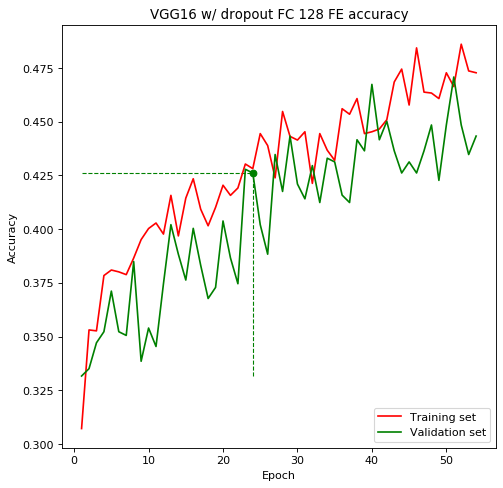

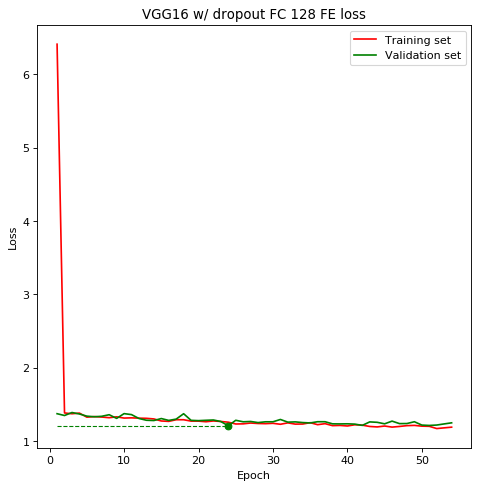

In [24]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [25]:
# Instantiate a VGG16 network with custom final layer
vgg16_fe_drop_256 = create_vgg16(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('vgg16_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
vgg16_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Train
history_vgg16_fe_drop_256 = vgg16_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 17.1893 - accuracy: 0.3168
Epoch 00001: val_loss improved from inf to 1.35608, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 16.3753 - accuracy: 0.3239 - val_loss: 1.3561 - val_accuracy: 0.3522
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3598 - accuracy: 0.3754
Epoch 00002: val_loss did not improve from 1.35608
19/19 [==============================] - 29s 2s/step - loss: 1.3641 - accuracy: 0.3715 - val_loss: 1.3594 - val_accuracy: 0.3299
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.3654 - accuracy: 0.3740
Epoch 00003: val_loss improved from 1.35608 to 1.34609, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3721 - accuracy: 0.3762 - val_loss: 1.3461 - val_a

Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1994 - accuracy: 0.4780
Epoch 00029: val_loss did not improve from 1.23660
19/19 [==============================] - 29s 2s/step - loss: 1.2010 - accuracy: 0.4758 - val_loss: 1.2872 - val_accuracy: 0.4433
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2126 - accuracy: 0.4739
Epoch 00030: val_loss improved from 1.23660 to 1.22692, saving model to vgg16_fe_drop_256_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.2141 - accuracy: 0.4728 - val_loss: 1.2269 - val_accuracy: 0.4467
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1714 - accuracy: 0.4898
Epoch 00031: val_loss did not improve from 1.22692
19/19 [==============================] - 29s 2s/step - loss: 1.1753 - accuracy: 0.4903 - val_loss: 1.2685 - val_accuracy: 0.4278
Epoch 32/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1939 - accuracy: 0.4798
Epoch 00032: val_loss did

18/19 [===========================>..] - ETA: 1s - loss: 1.1404 - accuracy: 0.4970
Epoch 00058: val_loss did not improve from 1.20005
19/19 [==============================] - 29s 2s/step - loss: 1.1430 - accuracy: 0.4959 - val_loss: 1.2430 - val_accuracy: 0.4485
Epoch 59/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1521 - accuracy: 0.4911
Epoch 00059: val_loss did not improve from 1.20005
19/19 [==============================] - 29s 2s/step - loss: 1.1518 - accuracy: 0.4934 - val_loss: 1.2131 - val_accuracy: 0.4622
Epoch 60/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1626 - accuracy: 0.4871
Epoch 00060: val_loss did not improve from 1.20005
19/19 [==============================] - 29s 2s/step - loss: 1.1591 - accuracy: 0.4903 - val_loss: 1.2421 - val_accuracy: 0.4364
Epoch 61/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1628 - accuracy: 0.4966
Epoch 00061: val_loss did not improve from 1.20005
19/19 [==============================]

In [27]:
# Save
models.save_model(vgg16_fe_drop_256, 'vgg16_fe_drop_256_4cl_end.h5')

In [28]:
# History of accuracy and loss
tra_loss_fe = history_vgg16_fe_drop_256.history['loss']
tra_acc_fe = history_vgg16_fe_drop_256.history['accuracy']
val_loss_fe = history_vgg16_fe_drop_256.history['val_loss']
val_acc_fe = history_vgg16_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_fe_drop_256 = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("VGG16 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 (w/ dropout) Feature Extraction

Epoch [end]: 79
Epoch [opt]: 49
Valid accuracy [end]: 0.4519
Valid accuracy [opt]: 0.4794
Test accuracy [end]:  0.4855
Test accuracy [opt]:  0.4656
Valid loss [end]: 1.2356
Valid loss [opt]: 1.2000
Test loss [end]:  1.1559
Test loss [opt]:  1.1842


In [33]:
models.load_model('vgg16_fe_drop_128_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4194432   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 516       
Total params: 18,909,636
Trainable params: 4,194,948
Non-trainable params: 14,714,688
_________________________________________________________________


In [34]:
vgg16_ft_1layer = models.load_model('vgg16_fe_drop_256_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in vgg16_ft_1layer.get_layer('vgg16').layers:
    if layer.name.startswith('block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_1layer.summary()
vgg16_ft_1layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 10,749,700
Non-trainable params: 12,354,880
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)      

In [35]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [36]:
# Train
history_ft = vgg16_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1685 - accuracy: 0.4857
Epoch 00001: val_loss improved from inf to 1.25425, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1628 - accuracy: 0.4869 - val_loss: 1.2542 - val_accuracy: 0.4467
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1324 - accuracy: 0.5143
Epoch 00002: val_loss improved from 1.25425 to 1.18643, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1352 - accuracy: 0.5118 - val_loss: 1.1864 - val_accuracy: 0.4691
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1307 - accuracy: 0.5107
Epoch 00003: val_loss improved from 1.18643 to 1.18315, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.1278 - 

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9771 - accuracy: 0.5756
Epoch 00029: val_loss improved from 1.12459 to 1.11322, saving model to vgg16_ft_1layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.9836 - accuracy: 0.5723 - val_loss: 1.1132 - val_accuracy: 0.5069
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9998 - accuracy: 0.5792
Epoch 00030: val_loss did not improve from 1.11322
19/19 [==============================] - 29s 2s/step - loss: 0.9959 - accuracy: 0.5834 - val_loss: 1.1527 - val_accuracy: 0.5258
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9845 - accuracy: 0.5837
Epoch 00031: val_loss did not improve from 1.11322
19/19 [==============================] - 29s 2s/step - loss: 0.9834 - accuracy: 0.5860 - val_loss: 1.1374 - val_accuracy: 0.5258
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9931 - accuracy: 0.5892
Epoch 00032: val_loss impro

Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9616 - accuracy: 0.5974
Epoch 00058: val_loss did not improve from 1.07553
19/19 [==============================] - 29s 2s/step - loss: 0.9651 - accuracy: 0.5963 - val_loss: 1.0975 - val_accuracy: 0.5464
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9521 - accuracy: 0.6001
Epoch 00059: val_loss did not improve from 1.07553
19/19 [==============================] - 29s 2s/step - loss: 0.9506 - accuracy: 0.6019 - val_loss: 1.1339 - val_accuracy: 0.5206
Epoch 60/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9279 - accuracy: 0.6087
Epoch 00060: val_loss did not improve from 1.07553
19/19 [==============================] - 29s 2s/step - loss: 0.9337 - accuracy: 0.6053 - val_loss: 1.0975 - val_accuracy: 0.5292
Epoch 61/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9271 - accuracy: 0.6114
Epoch 00061: val_loss did not improve from 1.07553
19/19 [==================

18/19 [===========================>..] - ETA: 1s - loss: 0.8728 - accuracy: 0.6382
Epoch 00087: val_loss did not improve from 1.02709
19/19 [==============================] - 29s 2s/step - loss: 0.8705 - accuracy: 0.6426 - val_loss: 1.1434 - val_accuracy: 0.5412
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9006 - accuracy: 0.6260
Epoch 00088: val_loss did not improve from 1.02709
19/19 [==============================] - 29s 2s/step - loss: 0.9006 - accuracy: 0.6251 - val_loss: 1.1073 - val_accuracy: 0.5378
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8668 - accuracy: 0.6400
Epoch 00089: val_loss did not improve from 1.02709
19/19 [==============================] - 29s 2s/step - loss: 0.8682 - accuracy: 0.6388 - val_loss: 1.0714 - val_accuracy: 0.5533
Epoch 90/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8892 - accuracy: 0.6300
Epoch 00090: val_loss did not improve from 1.02709
19/19 [==============================]

In [37]:
# Save
models.save_model(vgg16_ft_1layer, 'vgg16_ft_1layer_4cl_end.h5')

In [38]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_1layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning

Epoch [end]: 115
Epoch [opt]: 85
Valid accuracy [end]: 0.5258
Valid accuracy [opt]: 0.5515
Test accuracy [end]:  0.5511
Test accuracy [opt]:  0.5389
Valid loss [end]: 1.1116
Valid loss [opt]: 1.0271
Test loss [end]:  1.1326
Test loss [opt]:  1.0938


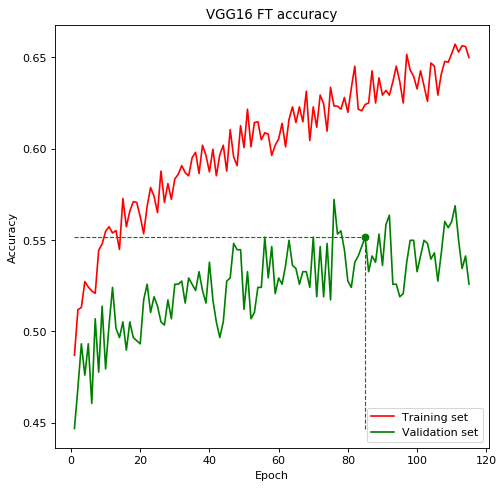

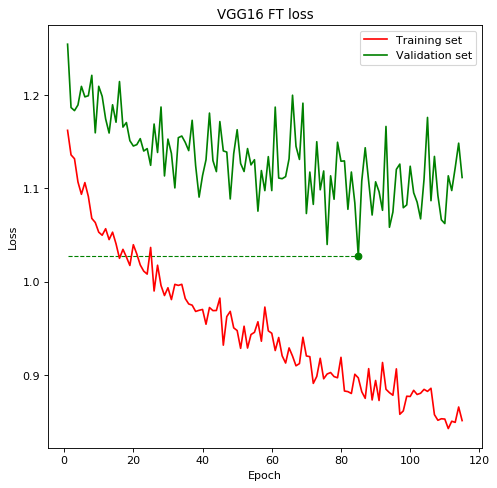

In [39]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [41]:
vgg16_ft_2layer = models.load_model('vgg16_ft_1layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_2layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_2layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_2layer.summary()
vgg16_ft_2layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 13,109,508
Non-trainable params: 9,995,072
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [42]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_2layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [43]:
# Train
history_ft_2layer = vgg16_ft_2layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 1.1777 - accuracy: 0.5556
Epoch 00001: val_loss improved from inf to 1.33882, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.1737 - accuracy: 0.5573 - val_loss: 1.3388 - val_accuracy: 0.4725
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9676 - accuracy: 0.5919
Epoch 00002: val_loss improved from 1.33882 to 1.08218, saving model to vgg16_ft_2layer_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 0.9705 - accuracy: 0.5899 - val_loss: 1.0822 - val_accuracy: 0.5619
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0300 - accuracy: 0.5765
Epoch 00003: val_loss did not improve from 1.08218
19/19 [==============================] - 29s 2s/step - loss: 1.0231 - accuracy: 0.5792 - val_loss: 1.1465 - val_accurac

18/19 [===========================>..] - ETA: 1s - loss: 0.8864 - accuracy: 0.6360
Epoch 00029: val_loss did not improve from 1.00282
19/19 [==============================] - 29s 2s/step - loss: 0.8871 - accuracy: 0.6379 - val_loss: 1.1301 - val_accuracy: 0.5344
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8811 - accuracy: 0.6382
Epoch 00030: val_loss did not improve from 1.00282
19/19 [==============================] - 30s 2s/step - loss: 0.8829 - accuracy: 0.6371 - val_loss: 1.0741 - val_accuracy: 0.5515
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8507 - accuracy: 0.6505
Epoch 00031: val_loss did not improve from 1.00282
19/19 [==============================] - 30s 2s/step - loss: 0.8531 - accuracy: 0.6486 - val_loss: 1.0303 - val_accuracy: 0.5636
Epoch 32/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8317 - accuracy: 0.6532
Epoch 00032: val_loss did not improve from 1.00282
19/19 [==============================]

In [44]:
# Save
models.save_model(vgg16_ft_2layer, 'vgg16_ft_2layer_4cl_end.h5')

In [45]:
# History of accuracy and loss
tra_loss_fe = history_ft_2layer.history['loss']
tra_acc_fe = history_ft_2layer.history['accuracy']
val_loss_fe = history_ft_2layer.history['val_loss']
val_acc_fe = history_ft_2layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_2layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_2layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (2 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

VGG16 Fine Tuning (2 layers)

Epoch [end]: 44
Epoch [opt]: 14
Valid accuracy [end]: 0.5464
Valid accuracy [opt]: 0.5670
Test accuracy [end]:  0.5847
Test accuracy [opt]:  0.5420
Valid loss [end]: 1.1839
Valid loss [opt]: 1.0028
Test loss [end]:  1.1387
Test loss [opt]:  1.0323


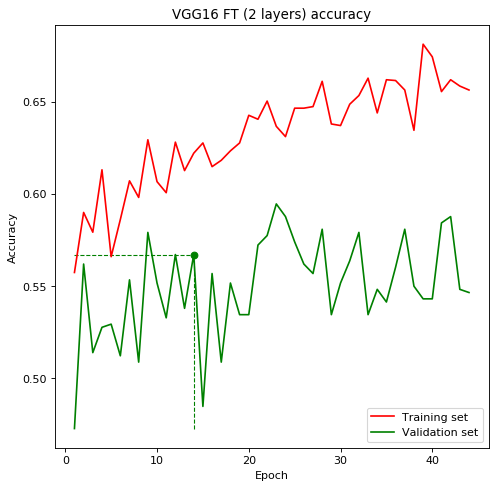

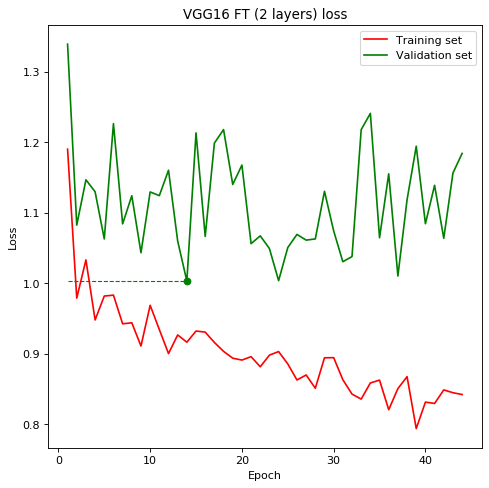

In [46]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (2 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [47]:
vgg16_ft_3layer = models.load_model('vgg16_ft_2layer_4cl_best.h5')

# Fine tuning: unfreeze the last two convolutional layers
for layer in vgg16_ft_3layer.get_layer('vgg16').layers:
    if layer.name in ('block5_conv1', 'block5_conv2', 'block5_conv3'):
        layer.trainable = True
    else:
        layer.trainable = False

# Recompile the model ()
vgg16_ft_3layer.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

vgg16_ft_3layer.summary()
vgg16_ft_3layer.get_layer('vgg16').summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 23,104,580
Trainable params: 15,469,316
Non-trainable params: 7,635,264
_________________________________________________________________
Model: "vgg16"
_________________________________________________________________
Layer (type)       

In [50]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'vgg16_ft_3layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [51]:
# Train
history_ft_3layer = vgg16_ft_3layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
 1/19 [>.............................] - ETA: 4:23WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: 


ResourceExhaustedError:  OOM when allocating tensor with shape[128,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_2/vgg16/block1_conv2/Conv2D (defined at <ipython-input-49-3027050e2599>:9) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_64118]

Function call stack:
distributed_function


In [ ]:
# Save
models.save_model(vgg16_ft_3layer, 'vgg16_ft_3layer_4cl_end.h5')

In [ ]:
# History of accuracy and loss
tra_loss_fe = history_ft_3layer.history['loss']
tra_acc_fe = history_ft_3layer.history['accuracy']
val_loss_fe = history_ft_3layer.history['val_loss']
val_acc_fe = history_ft_3layer.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_vgg16_ft_3layer = models.load_model('vgg16_ft_3layer_4cl_best.h5')
test_loss_fe, test_acc_fe = vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_vgg16_ft_3layer.evaluate(test_images, test_labels, verbose=False)

print("VGG16 Fine Tuning (3 layers)\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('VGG16 FT (3 layers) loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();